In [1]:
import sys
import os

current_dir = os.path.dirname(os.path.abspath('__file__'))

project_root = os.path.abspath(os.path.join(current_dir, '..'))

if project_root not in sys.path:
    sys.path.insert(0, project_root)

from utils.utils import load_image, apply, display_image, display_image_comparison, rgb_to_grayscale, generate_histogram, display_image_comparison_with_histogram, equalize_histogram, match_histogram

# Chapter 9: Histogram-Based Segmentation

## Image Segmentation

**Image segmentation** is the process of partitioning an image into multiple image segments, also known as image regions or image objects. Image segmentation is typically used to locate objects and boundaries (lines, curves, etc.) in images. More precisely, image segmentation is the process of assigning a label to every pixel in an image such that pixels with the same label share certain characteristics.

The simplest kind of image segmentation is object-background (or foreground-background) identification, where the goal is to group the pixels of object(s) in the image together, and the pixels of the  background together.


## Histogram Preprocessing

Before we can begin the process of histogram segmentation, we must first perform **histogram preprocessing**. We have already covered one form of histogram preprocessing in an earlier chapter, called histogram, equalization, another preprocessing step is called *histogram smoothing*.

We usually start with histogram equalization, which attempts to alter an image so its histogram is flat and spreads out over the entire range of gray levels. The result is an image with better contrast. 

The next preprocessing step is histogram smoothing. When examining a histogram, you look at peaks and valleys. Too many tall, thin, peaks and deep valleys will cause problems. Smoothing the histogram removes these spikes and fills in empty canyons while retaining the same basic shape of the histogram. We can achive this smoothing effect by sessentially applying a 1-dimensional low-pass filter to the histogram.

One may even start the process of histogram preprocessing with a preprocessed image, possibly using a high-pass filter or edge-detetor to make the object and background more distinct from each other

### Implementation

We have already implemented histogram equalization in a previous chapter.

In [2]:
from utils.utils import equalize_histogram, match_histogram

For histogram smoothing we'll first create a 1-D Gaussian kernel, then use NumPy's `convolve` function to apply it to the histogram 

In [3]:
import numpy as np
from numpy import convolve 

In [4]:
def generate_1d_gaussian_kernel(size: int, sigma: float = 1.0) -> np.ndarray:
    if size % 2 == 0:
        raise ValueError("Kernel size must be an odd number.")

    k = size // 2
    x = np.arange(-k, k + 1)

    K = np.exp(-x**2 / (2 * sigma**2))

    K /= np.sum(K)

    return K

### Examples

#### Example 1

In [6]:
image_1_path = "../TEST-IMAGES/ADDITIONAL/yacht.ppm"
image_1 = load_image(image_1_path)

Image Metadata for 'yacht.ppm':
 - Format: PPM
 - Size on Disk: 720.01 KB
 - Dimensions: 512x480 pixels
 - Mode: RGB
 - Channels: 3


Since the image is in RGB, we'll first have to convert it to grayscale.

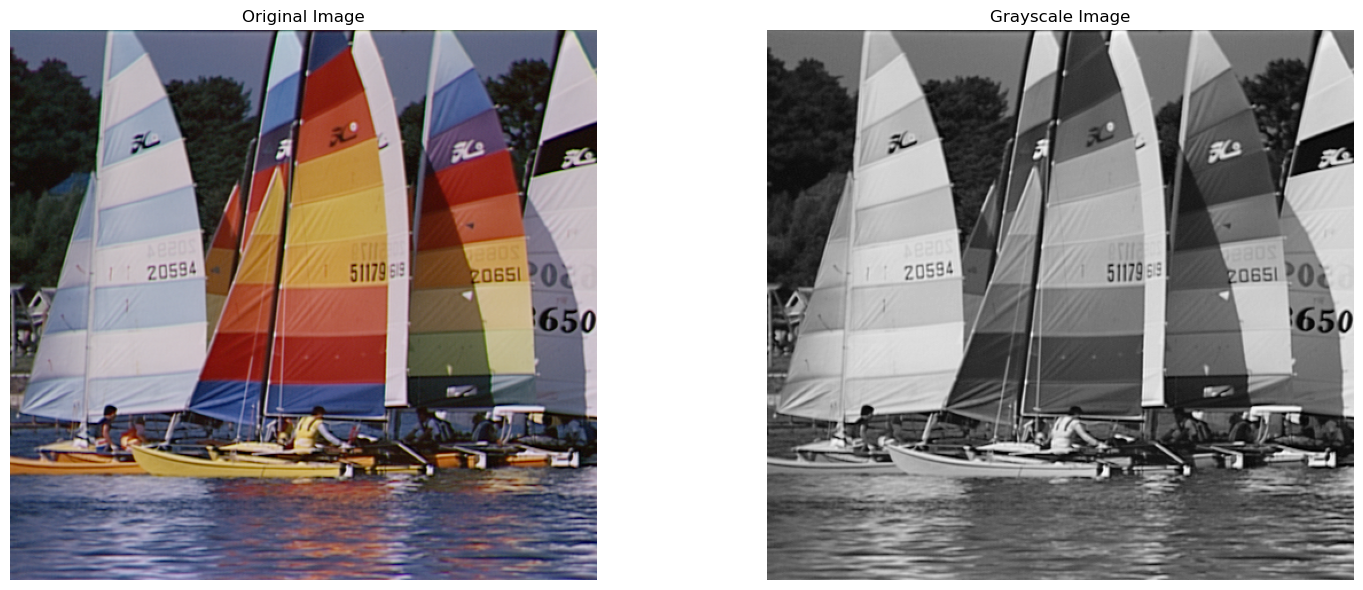

In [7]:
grayscale_image_1 = apply(image_1, rgb_to_grayscale)
display_image_comparison(image_1, grayscale_image_1, 'Original Image', 'Grayscale Image')

Lets start by equalizing the histogram of the image.

In [8]:
image_1_histogram = apply(grayscale_image_1, generate_histogram, return_array=True)
equalized_image_1_histogram = equalize_histogram(image_1_histogram)
equalized_image_1 = apply(grayscale_image_1, match_histogram, return_array=False, h=image_1_histogram, h_prime=equalized_image_1_histogram)

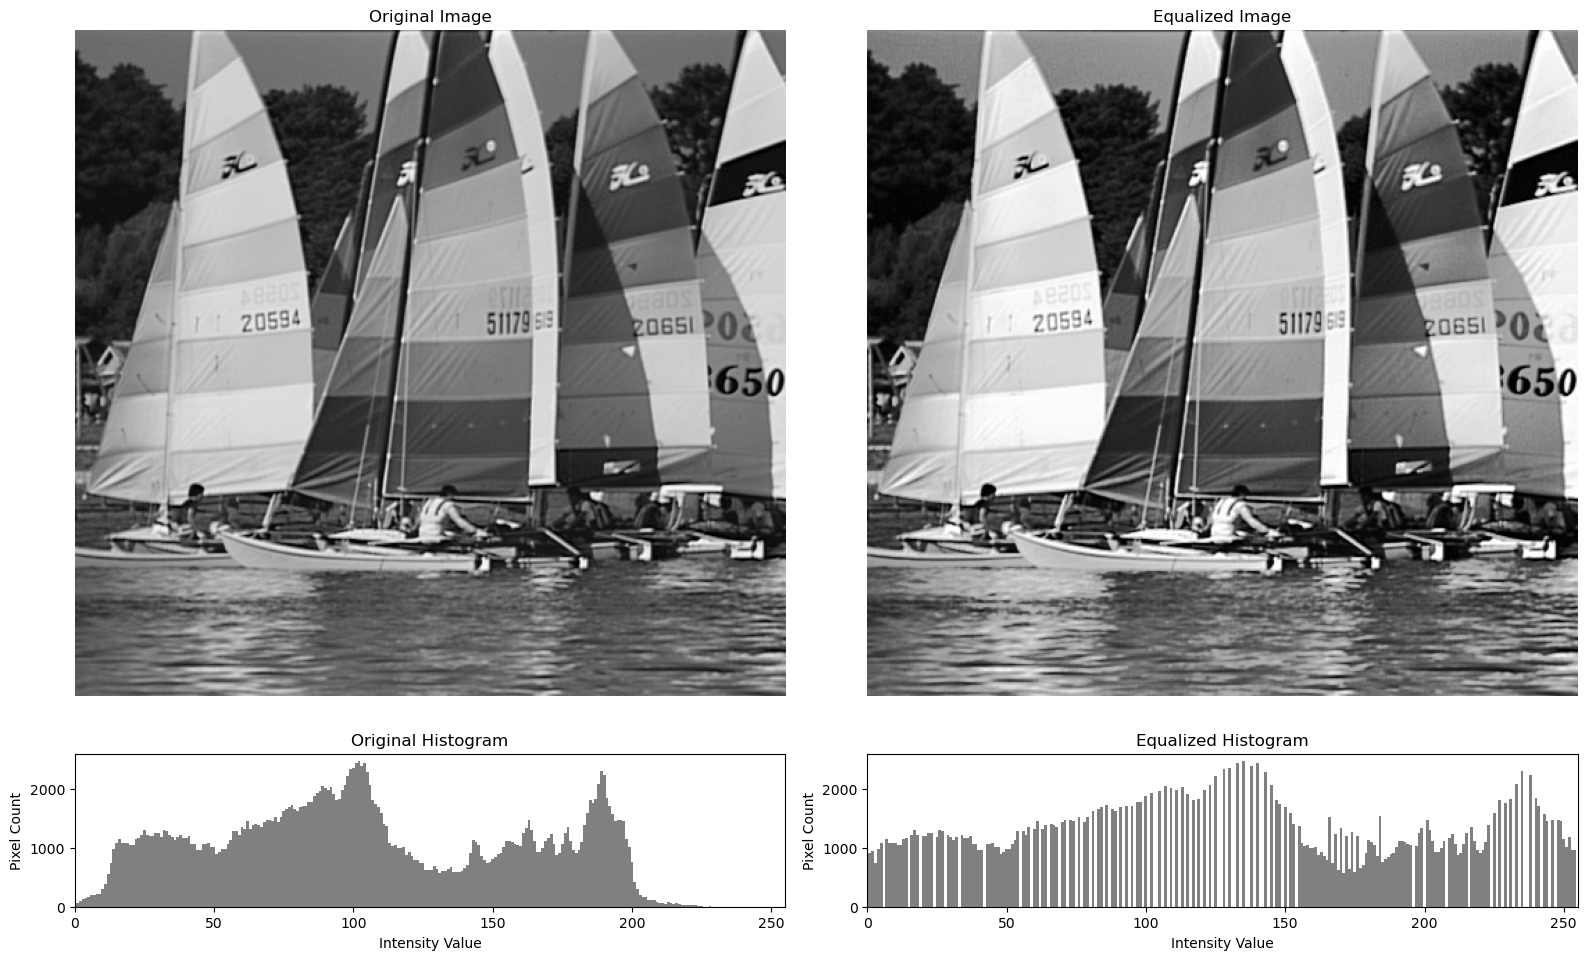

In [9]:
display_image_comparison_with_histogram(image_1=grayscale_image_1, histogram_1=image_1_histogram, image_2=equalized_image_1, histogram_2=equalized_image_1_histogram, title_1='Original Image',
                                            hist_title_1='Original Histogram', title_2='Equalized Image', hist_title_2='Equalized Histogram')

The next step is to smooth the histogram. We'll use a small value for sigma $\sigma$ when generating the Gaussian kernel as to not distort the histogram too much.

In [29]:
k = generate_1d_gaussian_kernel(3, 0.4)
smoothed_equalized_image_1_histogram = convolve(equalized_image_1_histogram, k, mode='same')
smoothed_equalized_image_1 = apply(equalized_image_1, match_histogram, return_array=False, h=equalized_image_1_histogram, h_prime=smoothed_equalized_image_1_histogram)

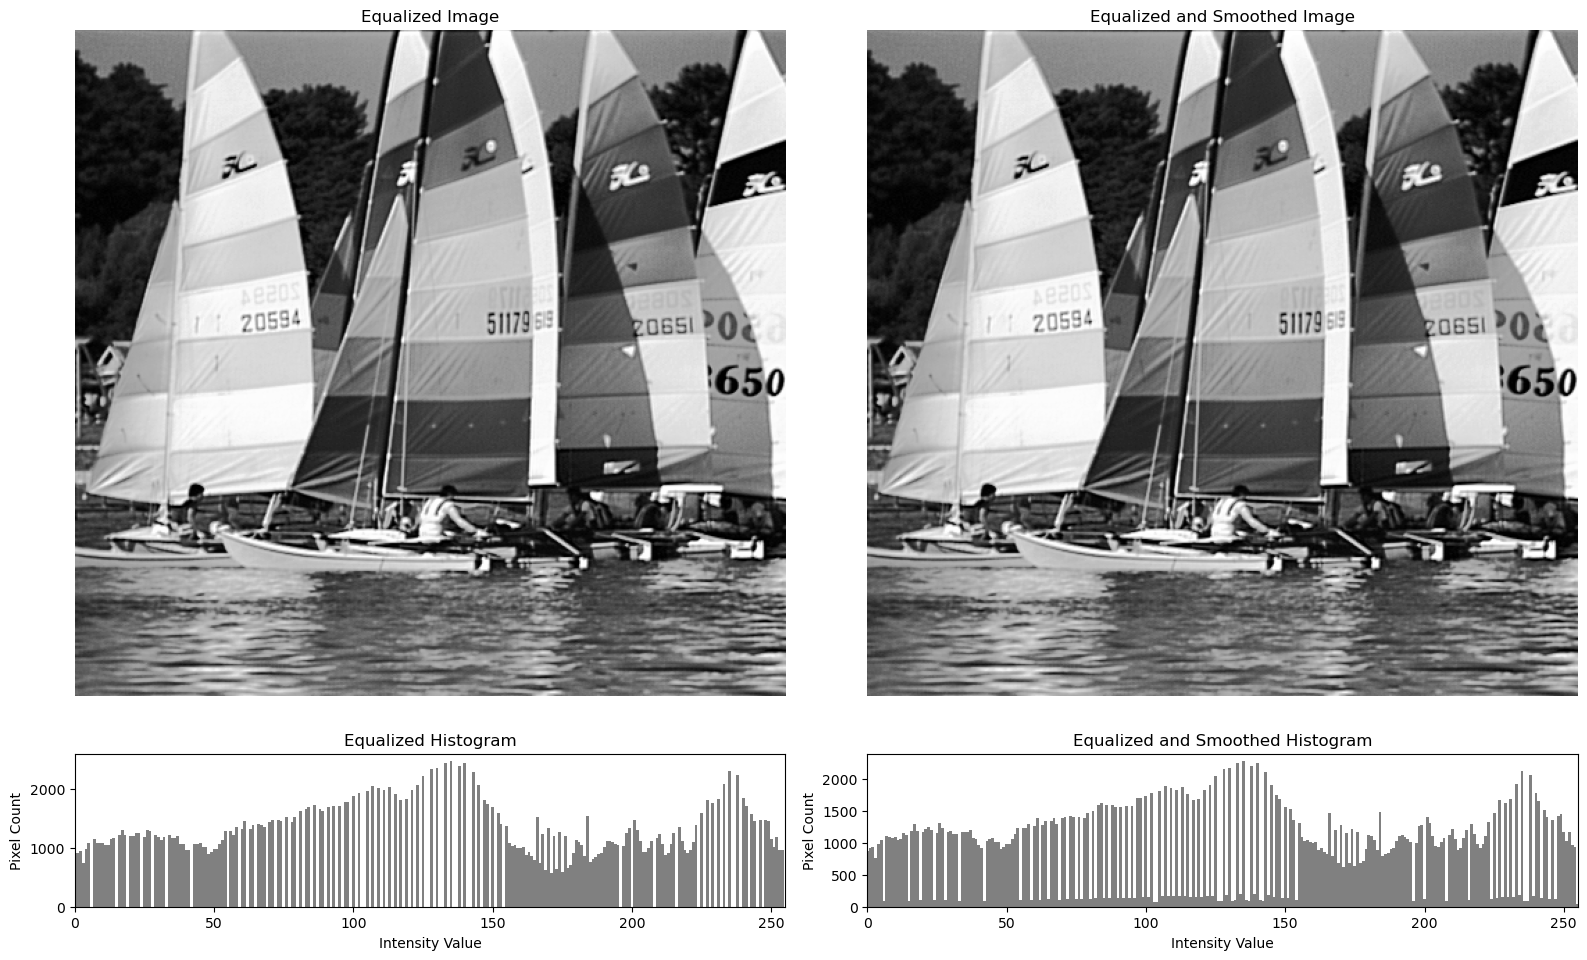

In [30]:
display_image_comparison_with_histogram(image_1=equalized_image_1, histogram_1=equalized_image_1_histogram, image_2=smoothed_equalized_image_1, histogram_2=smoothed_equalized_image_1_histogram, 
                                        title_1='Equalized Image', hist_title_1='Equalized Histogram', title_2='Equalized and Smoothed Image', hist_title_2='Equalized and Smoothed Histogram')

## Histogram-Based Segmentation

**Histogram-based image segmentation** is one of the simplest and most often used segmentation techniques. It uses the histogram to select the gray levels for grouping pixels into regions.

In a simple image there are two entities: the background and the object. The background is generally one gray level and occupies most of the image. Therefore, its gray level is a large peak in the histogram. The object or subject of the image is another gray level, and its gray level is another, smaller peak in the histogram.

### Histogram-Based Segmentation Techniques

There are four segmentation techniques: the manual technique, histogram peak technique, histogram valley technique, and an adaptive technique.